In [1]:
import torch
import re
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
%%capture
# Loading thepre-trained BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')  # You may need to customize this based on your specific BERT model architecture
bert_model.load_state_dict(torch.load('../input/bert_classifier.pth'))
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [3]:
def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) 
    
    punctuation = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuation:
        text = text.replace(p,'') 
    
    return text
df = pd.read_csv("../input/dataset_ita_eng_cleaned.csv", header = None)
df.columns = ['ID', 'text', 'label']
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [4]:
texts = df["text"].tolist()
labels =df["label"].tolist()

In [5]:
# Split the data into training and validation sets
_, test_texts, _, test_labels = \
train_test_split(texts, labels, random_state=42, test_size=0.2)

In [6]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Create a dataset for inference
test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)

# Create a data loader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, all_preds))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       735
           1       0.91      0.89      0.90      1706

    accuracy                           0.86      2441
   macro avg       0.83      0.84      0.83      2441
weighted avg       0.86      0.86      0.86      2441



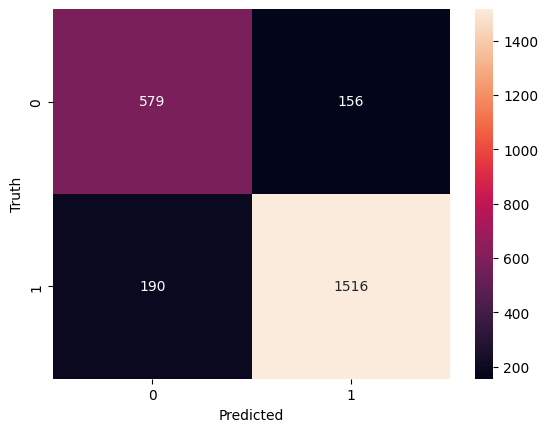

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# computing the confusion matrix
cm = confusion_matrix(test_labels, all_preds)

# creating a heatmap
plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()